# Normal Irrational Numbers As Pseudo-Random Number Generators

In this document, I will explore the possibility of using a 'normal' irrational number as the source of a pseudo-random number generator.

See the wikiperdia page: https://en.wikipedia.org/wiki/Normal_number

Which defines a 'normal number' as an irrational number whose digits in every base $b$ is distributed uniformly in the sense that each of the $b$ digit values has the same probability $1/b$, also all possible $b^2$ pairs of digits are equally likely with probability $1/b^2$, all $b^3$ triplets of digits equally likely with probability $1/b^3$, etc.

In [152]:
import sys
sys.path.append('C:/Users/Brendon/Dropbox/Scrypts/Statistics/python')

import statfunctions as sf
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

Here is an example of an algorithm used to calculate pi

In [91]:
def pi_gauss_legendre(n=3):
    """
    calculates pi using the gauss-legendre algorithm:
    https://en.wikipedia.org/wiki/Gauss–Legendre_algorithm
    
    inputs:
    n: (int) number of iterations
    
    output: (float) estimate of pi
    """
    # these are the seed parameters
    a = 1
    b = 1/np.sqrt(2)
    t = 1/4.
    p = 1
    
    # this is the rule for iterating the parameters:
    iterate_pi = lambda a, b, t, p: ((a + b)/2.,
                                     np.sqrt(a * b),
                                     t - p * ((a - b)/2.)**2,
                                     2 * p)
    
    # this is the estimate of pi on each iteration
    pi = lambda a, b, t, p: (a + b)**2 / (4 * t)
    
    # this evaluates pi to the specified degree of precision:
    for i in range(n):
        a, b, t, p = iterate_pi(a, b, t, p)
        
    return pi(a, b, t, p)

Here is a comparison between this calculation after 3 iterations and the numpy provided value for pi

In [92]:
print pi_gauss_legendre(3)
print np.pi

3.14159265359
3.14159265359


We are less interested in algorithms like those in `pi_gauss_legendre` because it is not so clear how to extract each digit from the algorithm (though if we studied it would could certainly extract such an algorithm). Instead we are interested in **spigot algorithms** that spit out the next digit in a sequence.

Here is a meta-class for `RandomNumberGenerator` based on these types of algorithms, and a specific instance `Pi`.

In [167]:
class RandomNumberGenerator(object):
    """
    this is a meta-class for describing random number
    generators based on normal irrational numbers.
    
    parameters to be specified in __init__:
    self.initial_params: (tuple) list of parameters the starts the algorithm
    self.decimal_location: (int) location of the decimal place relative to the digits produced
    self.output_parameter_index: (int) index for self.params that contains the output digit
    
    functions to be specified:
    self.iterate_digit: takes in arguments, and returns a tupe of the modifies arguments after
                        iterating the digit.
    """
    
    def __init__(self):
        self.initial_params = tuple()
        self.params = self.initial_params
        self.decimal_location = 0
        self.output_parameter_index = 0
    
    def reinitialize(self):
        self.params = self.initial_params
        return
    
    def iterate_digit(self,*args):
        pass
    
    def spigot(self):
        digit = int(self.params[self.output_parameter_index])
        self.params = self.iterate_digit(*self.params)
        return digit
        
    def iterator(self, number):
        for i in range(number):
            yield self.spigot()
            
    def evaluate(self, number):
        
        current_params = self.params
        self.reinitialize()
        
        digits = [str(i) for i in self.iterator(number)]
        
        self.params = current_params
        
        if self.decimal_location == 0:
            output = '0.' + ''.join(digits)
        elif self.decimal_location < 0:
            output = '0.' + ''.join(['0'] * abs(self.decimal_location)) * ''.join(digits)
        elif self.decimal_location > 0:
            output = ''.join(digits[0:self.decimal_location]) + '.' + ''.join(digits[self.decimal_location:])
        
        return output

class Pi(RandomNumberGenerator):
    
    def __init__(self):
        self.initial_params = (1, 0, 1, 1, 3, 3)
        self.params = self.initial_params
        self.decimal_location = 1
        self.output_parameter_index = 4
        
    def iterate_digit(self, q, r, t, k, m, x):
        
        q, r, t, k, m, x = ( 10 * q, 
                             10 * (r - m * t), 
                             t, 
                             k, 
                            (10 * (3 * q + r)) // t - 10 * m, 
                             x)
        
        while 4 * q + r - t >= m * t:
            q, r, t, k, m, x = ( q * k, 
                                (2 * q + r) * x, 
                                 t * x, k + 1, 
                                (q * (7 * k + 2) + r * x) // (t * x), 
                                 x + 2)
        
        return (q, r, t, k, m, x)

Here is the random number generator in action. Here, I can display the value of $pi$ to arbitrary precision (this is mainly as a check and does not change the state of the random number generator). Then I can spit out an arbitrary number of digits from pi and can perform statistical tests on them. With the current implimentation of the number generator, I can't reasonably generate more than around 10000 digits $-$ some of the parameters in `self.params` get very large and significantly slow down computation in this range.

In [168]:
pi = Pi()
print pi.evaluate(100)
digits = [i for i in pi.iterator(10000)]

3.141592653589793238462643383279502884197169399375105820974944592307816406286208998628034825342117067


Here is a function to generate histograms of digits, pairs of digits, etc... to verify normality of the random number generator.

In [163]:
def histograms(digits, orders=3):
    colors = sns.color_palette()
    types = ['digit', 'digit pair', 'digit triplet']
    for i in range(orders):
        
        items = [tuple(digits[(i + 1) * k + j] for j in range(i + 1)) for k in range(len(digits)//(i + 1))]
        S     = set(items)
        counts= np.array([items.count(s) for s in S])
        dcounts=np.sqrt(counts)
        x     = np.array(list(range(len(counts))))
        
        plt.subplot(2,2,i + 1)
        
        xlim = [-.5, len(S) - .5]
        y_range = max(counts + dcounts) - min(counts - dcounts)
        ylim = [min(counts - dcounts) - y_range/10., max(counts + dcounts) + y_range/10.]
        
        expected = (len(items)/float(len(S)))
        
        chi2, dchi2 = sf.chi_squared(counts - expected, dcounts, ddof=0)
        chi2string = sf.scientific_string(chi2,dchi2,style='latex')
        label = '$\chi^2 = ' + chi2string + '$'
        
        plt.errorbar(x, counts, dcounts,fmt='.', color=colors[0],alpha=.75, label=label)
        plt.plot(xlim, expected * np.array([1, 1]), '-', color=colors[0], alpha=1)
        plt.axis(xlim + ylim)
        plt.xlabel(types[i])
        plt.ylabel('counts')
        plt.legend(loc='best', frameon=True)
        
    plt.suptitle('distribution of digit and digit pairs for digits drawn from $\pi$',size=20)
    #plt.tight_layout()
        
    return

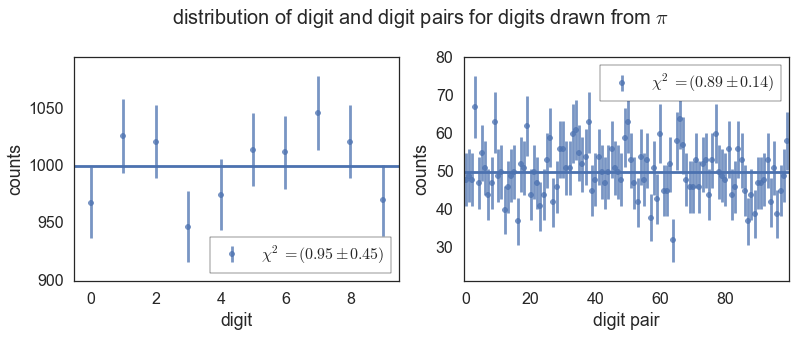

In [164]:
histograms(digits, 2)

It seems that irrational numbers are not good random number generators because they don't repeat, which means that the furthur along in the calculation I get, the larger the memory that I need to store to create the next number in the sequence becomes. Googling around I found some instances of generating digits of $\pi$ with speeds of order $O(n^3 \log{n}^3)$ and $O(n^2)$. Usual PRNGs can generate numbers with speeds of O(1).

Here is a comment that I saw on the internet regarding why $\pi$ is a bad PRNG:
(from https://www.quora.com/Why-do-we-need-random-number-generators-if-%CF%80-e-and-other-irrational-numbers-are-sources-of-non-repeating-digits)

Just to list a few reasons:

1. It is slow. Existing RNGs (Lagged Fibonacci, Mersenne twister, etc) can generate 10,000,000 numbers in a split second. How long will it take to compute 10,000,000 digits of pi?

2. Hard to restore previous state / set random seed. To find the n-th digit of pi, you usually have to find the previous n-1 digits (unless you are working on base 16). It is not a problem if you are using the random numbers only once, and do not need to set a random seed (it will still be considerably slower than existing RNGs). But if you want to start at the n-th digit of pi (e.g. when you continue a simulation you have previously stopped, you have to restore the state of the RNG), you will waste much time calculating the previous n-1 digits again.

3. It is memory consuming. Existing RNGs have a finite period, after which the numbers will repeat (though the period is so long that this is impossible to notice). Using pi or e does sound appealing since its digits are provably non repetitive, but this comes with a cost. Every RNG with finite state will eventually enter a loop. If a RNG won't enter a loop, its memory consumption has to be unbounded. For instance, you cannot compute the n-th digit of pi without computing the previous n-1 digits. Therefore the memory consumption grows as more digits are computed. After you have generated 10,000,000 random numbers using the digits of pi, your RNG will eat up (at least) several tens of MBs of your RAM.

4. A good random number generator should produce uniformly distributed integers, and also the joint distribution between two (and more) successive numbers generated should also be uniform. Existing RNGs can be tested that they approximately satisfy this property. The digits of pi and e are believed to exhibit this property (called "normal number"), but we don't have a proof yet.

Here is a paper that actually tried it:
http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6143212

Here is a more reputable looking investigating into PRNGs from irrational numbers:
http://www.emis.de/journals/EM/expmath/volumes/11/11.4/pp527_546.pdf

In [169]:
from scipy.special import erf

In [171]:
1 - erf(1/np.sqrt(2))

0.31731050786291415